# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from workspace_utils import active_session

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30), 
                                 transforms.RandomResizedCrop(224), 
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]), 
    'valid': transforms.Compose([transforms.Resize(256), 
                                 transforms.CenterCrop(224), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize([0.485, 0.456, 0.406],
                                                      [0.229, 0.224, 0.225])])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']), 
    'valid': datasets.ImageFolder(valid_dir, transform=data_transforms['valid']), 
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['valid'])
}


# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True), 
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True), 
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=True)
}

class_to_idx = image_datasets['train'].class_to_idx
# print(class_to_idx)

In [4]:
# testing datasets and dataloaders

print('data volume and length of loaders:')
print(f'len(training_data) Data volume: {len(image_datasets["train"])}')
print(f'len(trainingloader): {len(dataloaders["train"])}')
print(f'len(validationloader): {len(dataloaders["valid"])}')
print(f'len(testingloader): {len(dataloaders["test"])}')

print('=' * 36)

print('batch sizes for each loader:')
print(f'trainingloader.batch_size: {dataloaders["train"].batch_size}')
print(f'validationloader.batch_size: {dataloaders["valid"].batch_size}')
print(f'testingloader.batch_size: {dataloaders["test"].batch_size}')

print('=' * 36)
images, labels = next(iter(dataloaders['train']))

print('Checks of images and labels shapes:')
print(f'images.shape : {images.shape}')
print(f'labels.shape: {labels.shape}')
# print(f'labels: {labels}')
print('=' * 36)
print('test visualizing images:')
# imshow(images[0]);


data volume and length of loaders:
len(training_data) Data volume: 6552
len(trainingloader): 103
len(validationloader): 13
len(testingloader): 13
batch sizes for each loader:
trainingloader.batch_size: 64
validationloader.batch_size: 64
testingloader.batch_size: 64
Checks of images and labels shapes:
images.shape : torch.Size([64, 3, 224, 224])
labels.shape: torch.Size([64])
test visualizing images:


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

len(cat_to_name)
# print(cat_to_name)

102

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [ ]:
# TODO: Build and train your network

# break up the building, training, and validation for parts

In [ ]:
# Feed Forward Network (Classifier)

In [6]:
class Classifier(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers_sizes=[], dropp=0.2):
        '''Feedforward Classifier (Fully-Connected Network) with arbitrary hidden layers units.
        
            Arguments
            ---------
            in_features: (int) Size of the input layer
            out_features: (int) Size of the output layer
            hidden_layers: (list of int) list of hidden units, the sizes of the hidden layers
        '''
        super().__init__()
        
        self.hidden_layers_sizes = hidden_layers_sizes
        self.dropp = dropp
        
        # check if user make choice of zero hidden layers
        if not self.hidden_layers_sizes:
            # first layer is the last layer and it is the output layer(only in and out)
            self.layers = nn.ModuleList([nn.Linear(in_features, out_features)])
        
        else:
            # in case there are at least one or more hidden layers
            self.layers = nn.ModuleList([nn.Linear(in_features, self.hidden_layers_sizes[0])])
            self.layers.extend(Classifier._hidden_layers_init(self.hidden_layers_sizes))
            self.output = nn.Linear(hidden_layers_sizes[-1], out_features)
        
        # adding dropout to reduce overfitting
        self.dropout = nn.Dropout(dropp)
    
    def forward(self, in_features):
        '''Forward Pass through the Fully-Connected Classifier 
            
            returns the output logits
        '''
        # check if no hidden layers, then output taken and returned through first layer
        if not self.hidden_layers_sizes:
            for layer in self.layers:
                in_features = layer(in_features)
            return F.log_softmax(in_features, dim=1)
        
        # in case there are more than one layer in the classifier, then output taken and returned through last layer
        else:
            for layer in self.layers:
                in_features = F.relu(layer(in_features))
                in_features = self.dropout(in_features)
        
            in_features = self.output(in_features)
        
        return F.log_softmax(in_features, dim=1)

    @staticmethod
    def _hidden_layers_init(hidden_sizes):
        '''Helper Function that detect and shape hidden layers based on layers size 
           to be added to the classifier ModuleList later'''
        hidden_layers_units = zip(hidden_sizes[:-1], hidden_sizes[1:])

        return nn.ModuleList([nn.Linear(*layer) for layer in hidden_layers_units])

# ###################################################################################
# test
# classifier_test = Classifier(1024, 102, [512, 256, 128, 64])
# print(classifier_test)
# inputs = torch.rand(64, 1024)
# out_test = classifier_test(inputs)
# print(f'out_test.shape: {out_test.shape}')
# print(f'classifier_test.hidden_layers_sizes: {classifier_test.hidden_layers_sizes}')
# print(f'classifier_test.dropp: {classifier_test.dropp}')

In [ ]:
# model initializer function

In [7]:
# model initializer

def model_initializer(arch, out_features, hidden_units=[], drop_out=0.2, learnrate=0.001):
    '''Function that initialize the selected arch to be trained later.
    
            Arguments
            ---------
            arch: (str) the name of pre-trained model.
            out_features: (int) the number of class that model will predict.
            hidden_units: (list of int) list of hidden units for each hidden layer.
            learnrate: (float) the learning rate for the training process
            
            Returns
            -------
            arch: (str) the name of pre-trained model.
            model: (torchvisoin.models) pre-trained model initialized with new classifier.
            criterion: (nn.NLLLoss()) negative log likelihood loss.
            optimizer: (torch.optim) initialized optimizer for update weights matrices.
            device: (torch.device) the available device to work on.
            
    '''
    
    # Use GPU if it's available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #used models are: vgg19, alexnet, resnet34, and inception_v3
    archs_dict = {'vgg19': models.vgg19, 
                  'alexnet': models.alexnet, 
                  'resnet34': models.resnet34, 
                  'inception_v3': models.inception_v3
                 }
    
    # load the selected model from torchvision.models
    model = archs_dict[arch.lower()](pretrained=True)
    
    # getting input features of the original arch's classifier
    model_classifier = model.classifier if hasattr(model, 'classifier') else model.fc
    in_features = (
        model_classifier[0].in_features if isinstance(model_classifier, nn.Sequential) 
        else model_classifier.in_features
    )
    
    # Creating new FeedForward classifier to bind and train it with loaded model
    classifier = Classifier(in_features, out_features, hidden_layers_sizes=hidden_units, dropp=drop_out)
    
    # Freeze model's parameter to avoid updating them during backpropagation
    for param in model.parameters():
        param.requires_grad = False
    
    # attach the new classifier to the loaded model
    if hasattr(model, 'classifier'):
        model.classifier = classifier
    else:
        model.fc = classifier
    
    # define criterion
    criterion = nn.NLLLoss()
    
    # ** Train the classifier parameters
    optimizer = optim.Adam(
        model.classifier.parameters() if hasattr(model, 'classifier') else model.fc.parameters(), 
        lr=learnrate)
    
    # put model in current available device
    model.to(device)
    
    return (arch, model, criterion, optimizer, learnrate, device, 
            in_features, out_features, hidden_units, drop_out)


In [ ]:
# validation function

In [8]:
# function that will validate the model after each pass from trainingloader

def validation(model, validationloader, criterion):
    '''Function that validate the performance of a model 
       every epoch after each batch passed to the model
       
        Arguments
        ---------
        model: (torchvisoin.models) a model that in training phase.
        validationloader: (dataloader) data to be used for validate the after batch passed.
        criterion: (nn.NLLLoss()) negative log likelihood loss.
        
        Returns
        -------
        validation_loss: the total of Negative log likelihood loss for all samples provided.
        accuracy: the total accuracy for all samples provided.
    
    '''
    
    validation_loss, accuracy = 0, 0
    
    for inputs, labels in validationloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model(inputs)
        validation_loss += criterion(logps, labels).item()
        
        # get the probabilities
        ps = torch.exp(logps)
        
        # get top class with highest probability
        _, top_class = ps.topk(1, dim=1)
        
        # Calculate accuracy
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    return validation_loss, accuracy

In [ ]:
# train_model function

In [9]:
# function that will train the model

def train_model(model, criterion, optimizer, dataloaders, epochs=1):
    '''Function that will train the network of a model
       
        Arguments
        ---------
        model: (torchvisoin.models) a pre-trained arch model to trained.
        criterion: negative log likelihood loss.
        optimizer: (torch.optim) an optimizer for update weights matrices.
        dataloaders: (dict) dict of dataloaders to be used to feed the network in the training and validation phases.
        epochs: (int) number of epochs the model will be trained over the dataset.
        
        Returns
        -------
        model: (torchvisoin.models) pre-trained model with new trained classifier.
        optimizer: (torch.optim) trained optimizer for update weights matrices.
        training_losses: (list of floats) list of all training losses.
        validating_losses: (list of floats) list of all validation losses.
        accuracy_progress: (list of floats) list of all accuracy.
        epochs: number of epochs the network trained in.
        
    '''
    
    # track the running (current) training loss for a training phase
    current_training_loss = 0
    
    # tracking each epoch the overall losses for both training and validation phases, 
    # and all accuracy for each epoch
    training_losses, validating_losses, accuracy_progress = [], [], []
    
    # tracking the phase i.e. training or validation
    phases = ['train', 'valid']
    
    print('Training Progress during each epoch ...\n')
    
    for epoch in range(epochs):
        
        for phase in phases:
            if phase == 'train':
                model.train()
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    optimizer.zero_grad()
                    
                    logps = model(inputs)
                    loss = criterion(logps, labels)
                    
                    loss.backward()
                    optimizer.step()
                    
                    current_training_loss += loss.item()
                
            else:
                model.eval()
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, dataloaders[phase], criterion)
        
        # Keep tracking for looses for both pahses, and tracking accuracy
        training_losses.append(current_training_loss/len(dataloaders['train']))
        validating_losses.append(validation_loss/len(dataloaders['valid']))
        accuracy_progress.append(accuracy/len(dataloaders['valid']))
        
        
        print(
            f'Epoch: {epoch + 1}/{epochs}..  '
            f'Train Loss: {current_training_loss/len(dataloaders["train"]):.3f}..  '
            f'Validation Loss: {validation_loss/len(dataloaders["valid"]):.3f}..  '
            f'Validation Accuracy: {accuracy/len(dataloaders["valid"]):.3f}..  '
        )
        current_training_loss = 0
    
    print('\nTraining Done!....')
    
    return model, optimizer, training_losses, validating_losses, accuracy_progress, epochs


In [ ]:
# info about models liklely to train
# vgg19 (classifier): Linear(in_features=25088, out_features=4096, bias=True)
# alexnet (classifier): Linear(in_features=9216, out_features=4096, bias=True)
# resnet34 (fc): Linear(in_features=512, out_features=1000, bias=True)
# inception_v3 (fc): Linear(in_features=2048, out_features=1000, bias=True)

In [10]:
# run model_initializer and get its output as parameters for training and testing

out_features = len(cat_to_name)

intialization_results = model_initializer('vgg19', out_features, hidden_units=[1024], drop_out=0.2, learnrate=0.0001)

arch, model, criterion, optimizer, learnrate, device, *classifier = intialization_results

# test unpacking outputs
# print(*classifier)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:06<00:00, 93817024.36it/s] 


In [ ]:
# training attempts applied to VGG19 model:

# 1st: epochs = 15, dropout = 0.4, lr = 0.001,  batch_size  = 32, two hidden layers [1024, 512] neurons  -  Accuracy  79%
# 2nd: epochs = 10, dropout = 0.4, lr = 0.003,  batch_size  = 32, one hidden layer with [1024]  neurons  -  Accuracy  70%
# 3th: epochs = 10, dropout = 0.2, lr = 0.001,  batch_size  = 64, one hidden layer with [1024]  neurons  -  Accuracy  88%
# 4nd: epochs = 10, dropout = 0.2, lr = 0.0001, batch_size  = 64, one hidden layer with [1024]  neurons  -  Accuracy  92%
# 5nd: epochs = 20, dropout = 0.2, lr = 0.0001, batch_size  = 64, one hidden layer with [1024]  neurons  -  Accuracy  94%

In [11]:
with active_session():
    training_results = train_model(model, criterion, optimizer, dataloaders, epochs=20)

trained_model, trained_optimizer, training_losses, validating_losses, accuracy_progress, epochs = training_results

Training Progress during each epoch ...

Epoch: 1/20..  Train Loss: 2.867..  Validation Loss: 1.172..  Validation Accuracy: 0.745..  
Epoch: 2/20..  Train Loss: 1.381..  Validation Loss: 0.685..  Validation Accuracy: 0.848..  
Epoch: 3/20..  Train Loss: 1.007..  Validation Loss: 0.500..  Validation Accuracy: 0.897..  
Epoch: 4/20..  Train Loss: 0.828..  Validation Loss: 0.446..  Validation Accuracy: 0.884..  
Epoch: 5/20..  Train Loss: 0.724..  Validation Loss: 0.407..  Validation Accuracy: 0.896..  
Epoch: 6/20..  Train Loss: 0.663..  Validation Loss: 0.364..  Validation Accuracy: 0.908..  
Epoch: 7/20..  Train Loss: 0.606..  Validation Loss: 0.357..  Validation Accuracy: 0.898..  
Epoch: 8/20..  Train Loss: 0.561..  Validation Loss: 0.309..  Validation Accuracy: 0.908..  
Epoch: 9/20..  Train Loss: 0.531..  Validation Loss: 0.302..  Validation Accuracy: 0.918..  
Epoch: 10/20..  Train Loss: 0.456..  Validation Loss: 0.304..  Validation Accuracy: 0.921..  
Epoch: 11/20..  Train Loss: 

Visualizing the results for training VGG19 model....


Last Validation Accuracy: 94.01%
Last Validation Loss: 0.262
Last Train Loss: 0.361


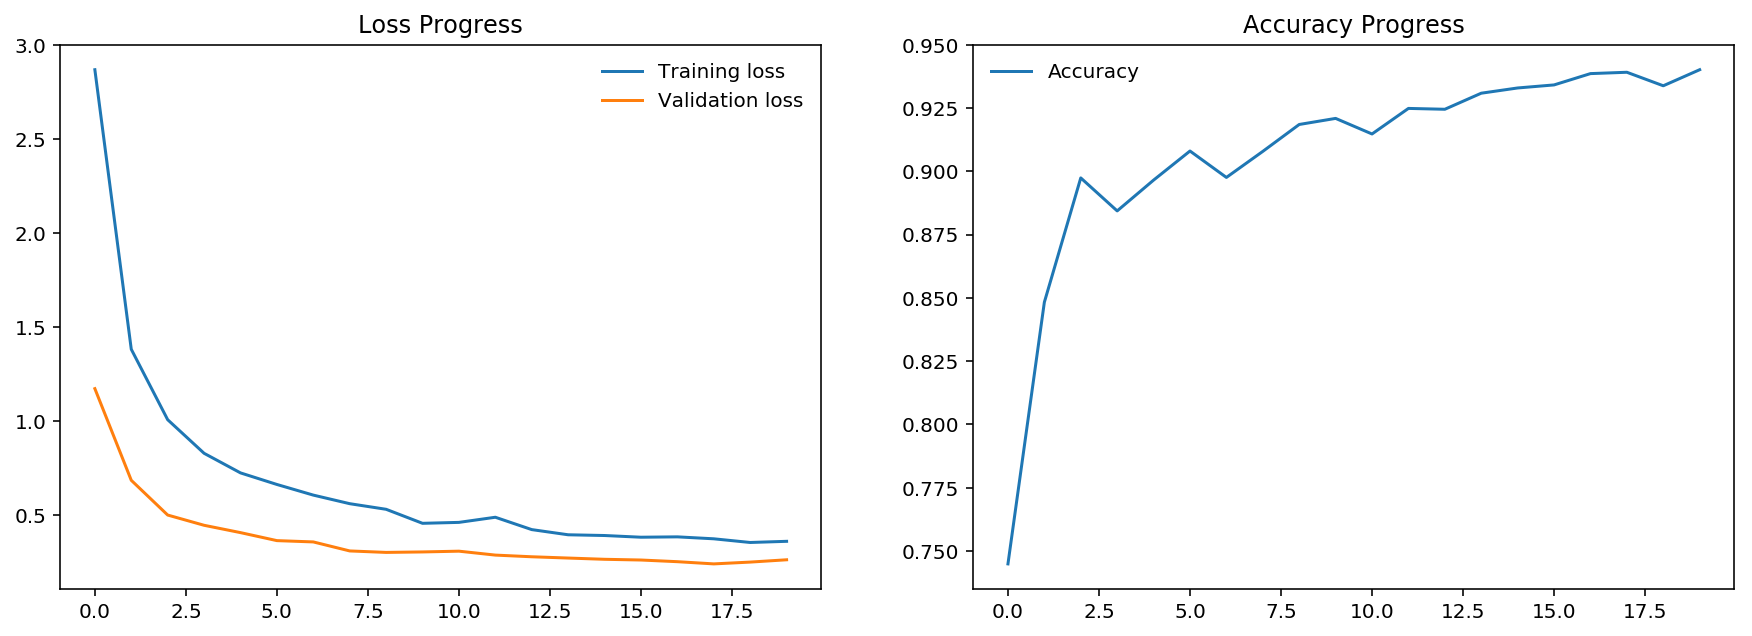

In [15]:
# trying to understand the results

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print('Visualizing the results for training VGG19 model....\n\n')

print(f'Last Validation Accuracy: {100 * accuracy_progress[-1]:.2f}%')
print(f'Last Validation Loss: {validating_losses[-1]:.3f}')
print(f'Last Train Loss: {training_losses[-1]:.3f}')



plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training loss')
plt.plot(validating_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title('Loss Progress')

plt.subplot(1, 2, 2)
plt.plot(accuracy_progress, label='Accuracy')
plt.legend(frameon=False)
plt.title('Accuracy Progress');


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [16]:
# TODO: Do validation on the test set

def testing(model, testingloader, criterion):
    '''Function that make (test) validate the performance of a trained model on test dataloader.
       
        Arguments
        ---------
        model: (torchvisoin.models) a trained model.
        testingloader: (dataloader) data to be used for validate the after training.
        criterion: (nn.NLLLoss()) negative log likelihood loss.
        
        Returns
        -------
        testing_loss: the total of Negative log likelihood loss for all samples provided.
        accuracy: the total accuracy for all samples provided.
        
    '''
    # move model to the current available device
    model.to(device)
    
    testing_loss, accuracy = 0, 0
    
    # put model in the eval mode
    model.eval()
    
    with torch.no_grad():
        for images, labels in testingloader:
            images, labels = images.to(device), labels.to(device)

            logps = model(images)
            testing_loss += criterion(logps, labels).item()

            # get the probabilities
            ps = torch.exp(logps)

            # get top class with highest probability
            _, top_class = ps.topk(1, dim=1)
            
            # Calculate accuracy
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
        accuracy = accuracy / len(testingloader)
        testing_loss = testing_loss / len(testingloader)
        
    return testing_loss, accuracy


In [ ]:
# Testing the network
# Apply testing after finish the train

In [18]:
criterion = nn.NLLLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

testing_results = testing(trained_model, dataloaders['test'], criterion)

testing_loss, accuracy = testing_results
print(f'Overall Testing Accuracy: {100 * accuracy:.2f}%')
print(f'Overall Testing Loss: {testing_loss:.2f}')

Overall Testing Accuracy: 92.31%
Overall Testing Loss: 0.31


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [19]:
# TODO: Save the checkpoint 

def model_saver(arch, model, classifier, optimizer, learnrate, 
                class_to_idx, training_losses, validating_losses, 
                accuracy_progress, epochs):
    
    # construct checkpoint dict
    checkpoint = {'arch': arch, 
                  'classifier': classifier,
                  'state_dict': model.state_dict(), 
                  'optimizer_state_dict': optimizer.state_dict(), 
                  'learnrate': learnrate, 
                  'class_to_idx': class_to_idx, 
                  'training_losses': training_losses, 
                  'validating_losses': validating_losses, 
                  'accuracy_progress': accuracy_progress, 
                  'training_loss': training_losses[-1], 
                  'validation_loss': validating_losses[-1], 
                  'validation_accuracy': accuracy_progress[-1],
                  'epochs': epochs
                  }
    
    # make the arch name prefix the checkpoint name when saving it
    checkpoint_name = f'{arch}_checkpoint.pth'
    
    torch.save(checkpoint, checkpoint_name)


In [ ]:
# Saving the trained model

In [20]:
# Saving model as checkpoint
model_saver(arch, trained_model, classifier, trained_optimizer, learnrate, 
            class_to_idx, training_losses, validating_losses, accuracy_progress, 
            epochs)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [21]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def model_loader(filepath):
    
    # loads checkpoint
    checkpoint= torch.load(filepath, map_location=lambda storage, loc: storage)
    
    # rebuild the model with appropriate arch and classifier
    
    # loads the arch
    model = getattr(models, checkpoint['arch'])(pretrained=True)
    
    # freeze early parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # loads classifier arguments and create it from the checkpoint
    classifier = Classifier(*checkpoint['classifier'])
    
    # attach the classifier to the model
    if hasattr(model, 'classifier'):
        model.classifier = classifier
    else:
        model.fc = classifier
    
    # loads the state dict of trained model from checkpoint into new model
    model.load_state_dict(checkpoint['state_dict'])
    
    # attach class_to_idx map to the new model
    model.class_to_idx = checkpoint['class_to_idx']

    # define an new optimizer with learning rate and update it with saved optimizer_state_dict
    # for continue training later.
    learnrate = checkpoint['learnrate']
    optimizer = optim.Adam(
        model.classifier.parameters() if hasattr(model, 'classifier') else model.fc.parameters(), 
        lr=learnrate)
    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [22]:
# Loading the trained model
vgg19_model, optimizer = model_loader('vgg19_checkpoint.pth')
# vgg19_model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Tensor object - tensor image
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

    # image = Image.open(image).resize((256, 256))
    image = Image.open(image, 'r')

    # image dims and aspect ratio
    width, height = image.size
    aspect_ratio = width / height

    #  keeping the aspect ratio resize, where the shortest side is 256 pixels
    
    # if width is shortest side make it 256, 
    # and resize height to be proportional with original aspect ratio
    width = 256 if aspect_ratio < 1 else int(256 * aspect_ratio)
    
    # if height is shortest side make it 256, 
    # and resize width to be proportional with original aspect ratio
    height = 256 if aspect_ratio > 1 else int(256 * (aspect_ratio ** -1))

    # resizing
    image = image.resize((width, height))
    
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    
    crop_width, crop_height = (224, 224)

    upper, left = (width - crop_width) // 2, (height - crop_height) // 2
    bottom, right = (width + crop_width) // 2, (height + crop_height) // 2
    crop_box = (upper, left, bottom, right) 
    croped_image = image.crop(crop_box)

    np_img = ((np.array(croped_image) / 255.0) - means) / stds
    
    tensor_img = torch.from_numpy(np_img.transpose(2, 0, 1))
    
    return tensor_img


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [24]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

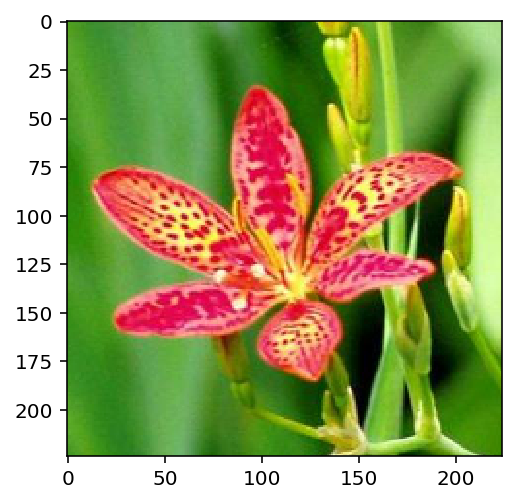

In [25]:
# test process_image function
image = process_image(test_dir +'/102/image_08023.jpg')
imshow(image);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [43]:
# predict function

In [26]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    
    # Use GPU torch when available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # move model to the available device
    model.to(device)
    
    # mapping indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    
    # get tensor object(image)
    image = process_image(image_path)
    image = image.float().unsqueeze_(0)
    
    # move image to available device
    image = image.to(device)
    
    # set model to eval mode
    model.eval()
    
    with torch.no_grad():
        output = model(image)
        
        # get the probabilities
        ps = torch.exp(output)
    
        # get top 5 classes with highest probabilities
        probs, indices = ps.topk(topk, dim=1)
        
        probs = probs.tolist()[0]
        classes = [idx_to_class[idx] for idx in indices.tolist()[0]]
        
    return probs, classes


In [27]:
# Test predict function
image_path = test_dir +'/102/image_08023.jpg'
model = vgg19_model

probs, classes = predict(image_path, vgg19_model)
print(f'props: {probs}')
print(f'classes: {classes}')


props: [0.9999561309814453, 4.210692350170575e-05, 1.2013314290015842e-06, 4.884577151642588e-07, 1.281552073351122e-07]
classes: ['102', '79', '77', '73', '18']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes

In [28]:
def sanity_checking(img_path, probs, classes, names_dict):
    
    # get tensor image for model
    img = process_image(img_path)
    
    # get image name
    img_name = names_dict[img_path.split('/')[-2]]
    
    # get actual flowers names
    flowers_names = [names_dict[id] for id in classes]
    
    # set up figure to plot
    plt.figure(figsize=(5, 10))
    
    # ploting
    
    # plot flower iamge
    plt.subplot(2, 1, 1)
    
    ax1 = plt.gca()
    ax1.axis('off')
    imshow(img, ax1)
    plt.title(img_name)
    
    
    # plot bars fig
    plt.subplot(2, 1, 2)
    
    bars_coordinates = np.arange(len(probs))
    plt.barh(bars_coordinates, probs, align='center', )
    y_pos = np.arange(len(flowers_names))
    plt.yticks(y_pos, flowers_names)
    ax2 = plt.gca()
    ax2.invert_yaxis()

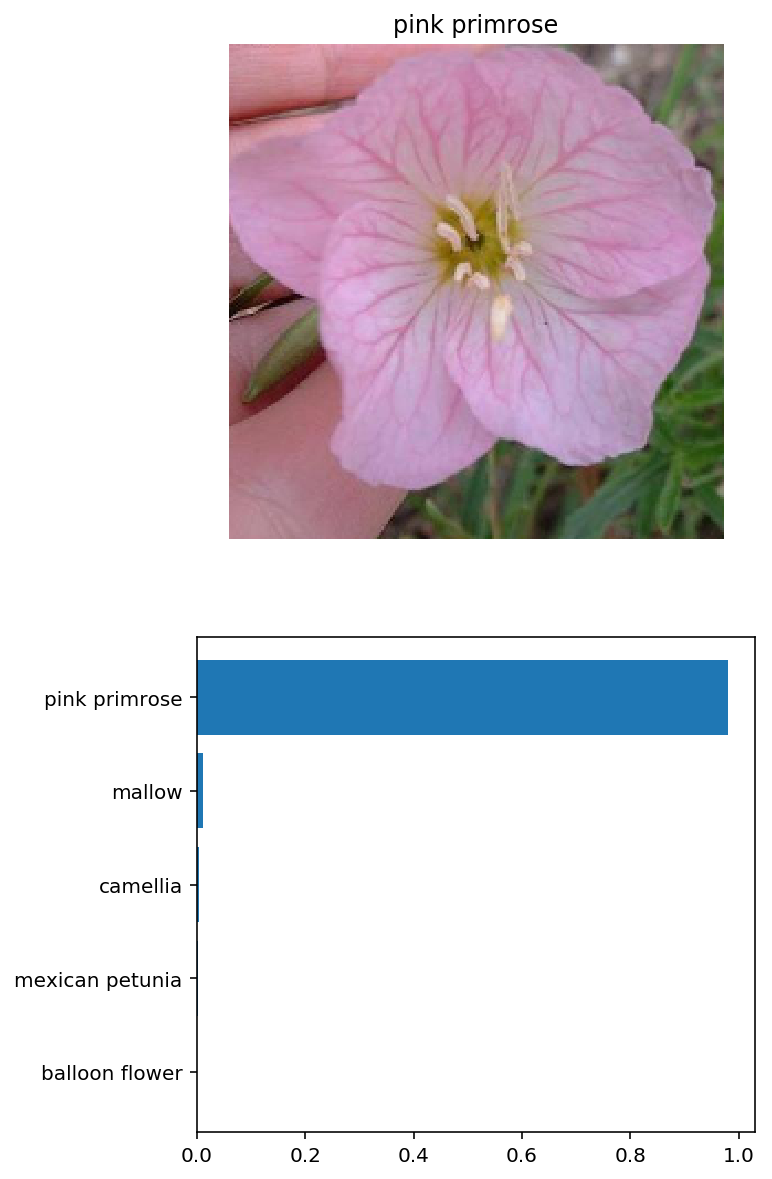

In [29]:
# test sanity_checking function

image_path = test_dir +'/1/image_06754.jpg'
model = vgg19_model

probs, classes = predict(image_path, vgg19_model)

sanity_checking(image_path, probs, classes, cat_to_name)

<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [2]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace